## Get Scenario Data

In [1]:
from tutorials.utils.tutorial_utils import setup_notebook
setup_notebook()
import os
NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', '../../nuplan/dataset')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', '../../nuplan/dataset/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', '../../nuplan/dataset/nuplan-v1.1/splits/mini')
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')

In [2]:
from nuplan.planning.script.builders.scenario_building_builder import build_scenario_builder
from nuplan.planning.script.builders.scenario_filter_builder import build_scenario_filter
from nuplan.planning.script.builders.worker_pool_builder import build_worker

### set up config file - edit in the config access to change ###
import hydra
CONFIG_PATH = "../nuplan/planning/script/config/common/myconfigs"
CONFIG_NAME = "scenario_access"
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[])
###

### create all scenario objects as specified in config file ###
scenario_builder = build_scenario_builder(cfg)
scenario_filter = build_scenario_filter(cfg.scenario_filter)
worker = build_worker(cfg)
scenarios = scenario_builder.get_scenarios(scenario_filter, worker) # List[AbstractScenario]

In [3]:
s = scenarios[1]

## Get Reference Lane From Map Data

In [4]:
s.map_api

In [5]:
from nuplan.common.actor_state.state_representation import Point2D
from nuplan.common.maps.abstract_map import SemanticMapLayer
from matplotlib import pyplot as plt

from nuplan.common.actor_state.ego_state import EgoState
from nuplan.common.maps.abstract_map_objects import LaneGraphEdgeMapObject
from typing import List, Tuple
from nuplan.planning.simulation.planner.utils.breadth_first_search import BreadthFirstSearch
import math

# get route plan from map
route_roadblocks_ids = s.get_route_roadblock_ids()

route_roadblocks = []
for id_ in route_roadblocks_ids:
    block = s.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK)
    block = block or s.map_api.get_map_object(id_, SemanticMapLayer.ROADBLOCK_CONNECTOR)
    route_roadblocks.append(block)

# candidate lane IDs
candidate_lane_edge_ids = [edge.id for block in route_roadblocks if block for edge in block.interior_edges]

def get_starting_edge(ego_state: EgoState) -> LaneGraphEdgeMapObject:
    
    starting_edge = None
    closest_dist = math.inf
    found_on_roadblock = False
    for edge in route_roadblocks[0].interior_edges + route_roadblocks[1].interior_edges:
        if edge.contains_point(ego_state.center):
            starting_edge = edge
            found_on_roadblock = True
            break
        # case ego does not start on a road block
        distance = edge.polygon.distance(ego_state.car_footprint.geometry)
        if distance < closest_dist:
            starting_edge = edge
            closest_dist = distance
    
    if not found_on_roadblock:
        print('Picking closest approx')
    return starting_edge

def bfs(ego_state: EgoState) -> Tuple[List[LaneGraphEdgeMapObject], bool]:
    starting_edge = get_starting_edge(ego_state)
    graph_search = BreadthFirstSearch(starting_edge, candidate_lane_edge_ids)
    offset = 1 if starting_edge.get_roadblock_id() == route_roadblocks[1].id else 0
    route_plan, path_found = graph_search.search(route_roadblocks[-1], len(route_roadblocks[offset:]))
    if not path_found:
        logger.warning('Path not found')
    return route_plan, path_found

current_lane_path, found = bfs(s.initial_ego_state)
assert(found == True)

In [6]:
len(current_lane_path)

19

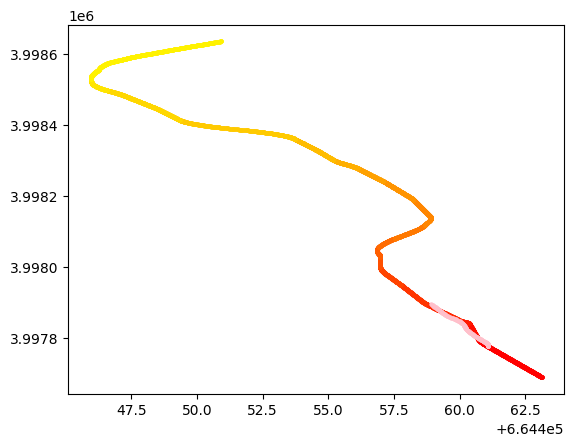

In [7]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy as np 
 
cmap = cm.autumn
norm = Normalize(vmin=0, vmax=len(current_lane_path))

col = 0
for lane in current_lane_path:
    route = lane.baseline_path.discrete_path
    discrete_lane_x, discrete_lane_y = [pt.x for pt in route], [pt.y for pt in route]
    plt.scatter(discrete_lane_x, discrete_lane_y, color=cmap(norm(col)), s=5, label='bfs ego path')
    col += 1

def get_xy_from_egostate(ego):
        return ego.waypoint._oriented_box.center.x, ego.waypoint._oriented_box.center.y

future_ego_pos = []
for ego in s.get_ego_future_trajectory(0, s.duration_s.time_s):
    future_ego_pos.append(get_xy_from_egostate(ego))
future_ego_pos = np.array(future_ego_pos)

plt.scatter(future_ego_pos[:, 0], future_ego_pos[:, 1], color = 'pink', s=5, label='true ego path')

In [8]:
get_xy_from_egostate(s.initial_ego_state)

(664461.0721685191, 3997777.899627016)

## Get shortened path

In [9]:
full_bfs = [] 

for lane in current_lane_path:
    full_bfs += lane.baseline_path.discrete_path

In [10]:
init = s.initial_ego_state.center
fin = s.get_expert_goal_state()

init_dist = float('inf')
fin_dist = float('inf')

init_id = 0
fin_id = 0

for idx in range(len(full_bfs)):
    if init_dist > full_bfs[idx].distance_to(init):
        init_dist = full_bfs[idx].distance_to(init)
        init_id = idx
    if fin_dist > full_bfs[idx].distance_to(fin):
        fin_dist = full_bfs[idx].distance_to(fin)
        fin_id = idx

In [11]:
ref_path = full_bfs[init_id:fin_id+1]
ref_path_x, ref_path_y = [pt.x for pt in ref_path], [pt.y for pt in ref_path]

Text(0.5, 1.0, 'True vs Reference path using BFS')

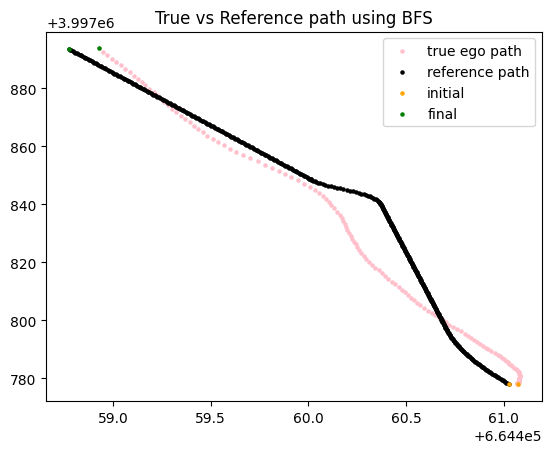

In [12]:
plt.scatter(future_ego_pos[:, 0], future_ego_pos[:, 1], color = 'pink', s=5, label='true ego path')
plt.scatter(ref_path_x, ref_path_y, color = 'black', s=5, label='reference path')

plt.scatter(future_ego_pos[0, 0], future_ego_pos[0, 1], color = 'orange', s=5, label='initial')
plt.scatter(ref_path_x[0], ref_path_y[0], color = 'orange', s=5)

plt.scatter(future_ego_pos[-1, 0], future_ego_pos[-1, 1], color = 'g', s=5, label='final')
plt.scatter(ref_path_x[-1], ref_path_y[-1], color = 'g', s=5)

plt.legend()
plt.title('True vs Reference path using BFS')

In [13]:
len(ref_path)

467

In [14]:
len(future_ego_pos)

148